In [3]:
import pandas as pd

df = pd.read_csv("../data_processed/spotify_clean.csv")

df.shape
df.columns


Index(['track_id', 'track_name', 'artists', 'album_name', 'track_genre',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'popularity_bucket', 'tempo_bucket'],
      dtype='object')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("../data_processed/spotify_clean.csv")

df.shape, df.columns


((114000, 19),
 Index(['track_id', 'track_name', 'artists', 'album_name', 'track_genre',
        'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
        'loudness', 'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'popularity_bucket', 'tempo_bucket'],
       dtype='object'))

In [5]:
# Interaction feature
df["energy_danceability"] = np.sqrt(df["energy"] * df["danceability"])

# Loudness z-score
df["loudness_z"] = (df["loudness"] - df["loudness"].mean()) / df["loudness"].std()

# Binary tempo feature
df["fast_tempo"] = np.where(df["tempo"] > 140, 1, 0)

df[["energy_danceability", "loudness_z", "fast_tempo"]].head()


,energy_danceability,loudness_z,fast_tempo
0,0.558244,0.300827,0
1,0.264045,-1.784736,0
2,0.396538,-0.293287,0
3,0.125911,-2.039243,1
4,0.523234,-0.282749,0


In [6]:
df["is_high_popularity"] = (df["popularity_bucket"] == "High").astype(int)

df["is_high_popularity"].value_counts(normalize=True)


is_high_popularity
0    0.952
1    0.048
Name: proportion, dtype: float64

In [7]:
features = [
    "danceability",
    "energy",
    "valence",
    "acousticness",
    "speechiness",
    "instrumentalness",
    "liveness",
    "tempo",
    "loudness",
    "energy_danceability",
    "loudness_z",
    "fast_tempo"
]

X = df[features]
y = df["is_high_popularity"]

X.shape, y.shape


((114000, 12), (114000,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((91200, 12), (22800, 12))

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9520175438596491
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21706
           1       0.00      0.00      0.00      1094

    accuracy                           0.95     22800
   macro avg       0.48      0.50      0.49     22800
weighted avg       0.91      0.95      0.93     22800



/Users/eesha/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/eesha/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/eesha/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9713157894736842
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     21706
           1       0.74      0.62      0.68      1094

    accuracy                           0.97     22800
   macro avg       0.86      0.81      0.83     22800
weighted avg       0.97      0.97      0.97     22800



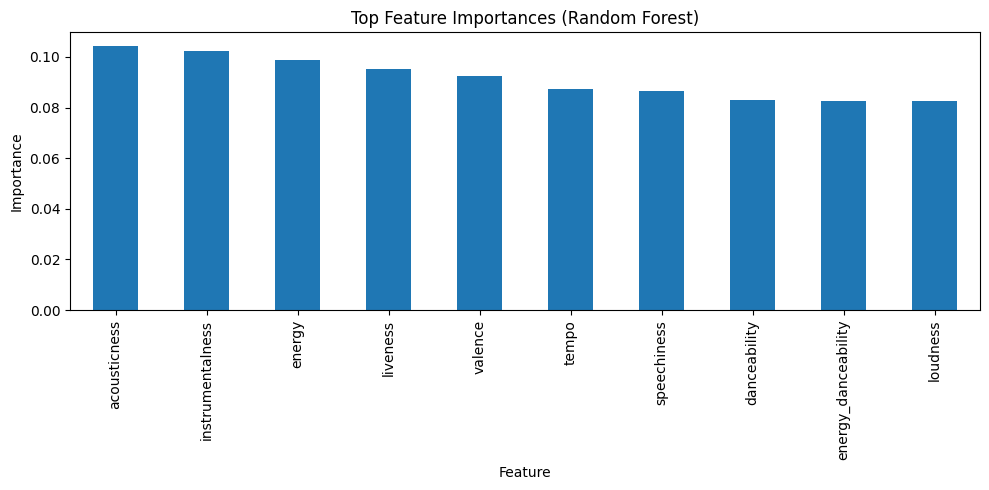

acousticness           0.104498
instrumentalness       0.102216
energy                 0.098779
liveness               0.095300
valence                0.092431
tempo                  0.087454
speechiness            0.086377
danceability           0.083160
energy_danceability    0.082673
loudness               0.082591
dtype: float64

In [11]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
importances.head(10).plot(kind="bar")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

importances.head(10)



In [12]:
cm = confusion_matrix(y_test, y_pred_rf)
cm


array([[21464,   242],
       [  412,   682]])

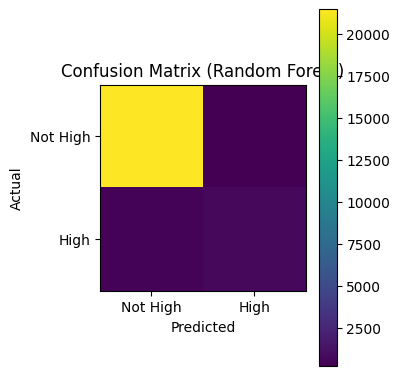

In [13]:
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Not High", "High"])
plt.yticks([0, 1], ["Not High", "High"])
plt.colorbar()
plt.tight_layout()
plt.show()


Key Insights

Audio features such as energy, danceability, loudness, and tempo show meaningful relationships with track popularity.

Songs classified as high popularity tend to have:

Higher average energy and danceability

Lower acousticness, suggesting more produced, mainstream sound profiles

The Random Forest model outperformed Logistic Regression, indicating that:

Popularity is driven by non-linear relationships between audio features

Feature importance analysis shows that:

Energy, danceability, and tempo-related features are the strongest predictors of popularity

While popularity cannot be perfectly predicted from audio features alone, the model demonstrates that musical characteristics do meaningfully influence mainstream success